In [1]:
import numpy as np
import torch
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
from preprocess import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fix random seed
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)      
torch.cuda.manual_seed(0)

In [2]:
data_list = load_data()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Seed_CNN(nn.Module):
    def __init__(self, in_channels=5, n_classes=3):
        super(Seed_CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # self.bn2 = nn.BatchNorm2d(32)
    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=(0,1))

        self.flat_dim = 16 * 4 * 5
        
        self.fc1 = nn.Linear(self.flat_dim, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, n_classes)

    def forward(self, x):
        # shape : (N, 5, 8, 9)
        # x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # x = F.relu(self.bn1(self.conv1(x)))
        # x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
CNN_batch_size = 32
CNN_lr = 1e-4
CNN_epochs = 10
n_classes = 3

CNN_acc_list = []

for i in range(12):

    X_train, Y_train, X_test, Y_test = merge_data(data_list, i)
    X_train = get_CNN_data(X_train)
    X_test = get_CNN_data(X_test)
    
    train_dataset = SeedDataset(X_train, Y_train, augment=False)
    test_dataset = SeedDataset(X_test, Y_test, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=CNN_batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=CNN_batch_size, shuffle=False)

    model = Seed_CNN(in_channels=5, n_classes=n_classes).to(device)

    classes, counts = np.unique(Y_train, return_counts=True)
    weights = 1.0 / counts           
    weights = weights / weights.sum() * len(classes) 
    weights = torch.tensor(weights, dtype=torch.float32).to(device)

    criterion = nn.CrossEntropyLoss(weight=weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=CNN_lr, weight_decay=1e-4)

    train_acc_list = []
    test_acc_list = []

    for epoch in range(CNN_epochs):
        model.train()
        correct_train = 0
        total_train = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            pred = out.argmax(dim=1)
            correct_train += (pred == yb).sum().item()
            total_train += yb.size(0)

        train_acc = correct_train / total_train
        train_acc_list.append(train_acc)

        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                pred = out.argmax(dim=1)
                correct_test += (pred == yb).sum().item()
                total_test += yb.size(0)
        test_acc = correct_test / total_test
        test_acc_list.append(test_acc)

        print(f"Epoch {epoch+1}/{CNN_epochs} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    CNN_acc_list.append(test_acc_list[-1]) 

    # # ------------------ 绘图 ------------------
    # plt.figure(figsize=(8,5))
    # plt.plot(range(1, CNN_epochs+1), train_acc_list, label='Train Acc')
    # plt.plot(range(1, CNN_epochs+1), test_acc_list, label='Test Acc')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.title(f'Subject {i} Train/Test Accuracy')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

print(CNN_acc_list)
    




(27786, 5, 8, 9)
(2526, 5, 8, 9)
Epoch 1/10 - Train Acc: 0.7689, Test Acc: 0.4529
Epoch 2/10 - Train Acc: 0.9367, Test Acc: 0.4418
Epoch 3/10 - Train Acc: 0.9823, Test Acc: 0.3971
Epoch 4/10 - Train Acc: 0.9951, Test Acc: 0.4228
Epoch 5/10 - Train Acc: 0.9987, Test Acc: 0.4228
Epoch 6/10 - Train Acc: 0.9995, Test Acc: 0.4228
Epoch 7/10 - Train Acc: 0.9999, Test Acc: 0.3828
Epoch 8/10 - Train Acc: 0.9998, Test Acc: 0.3401
Epoch 9/10 - Train Acc: 0.9999, Test Acc: 0.3979
Epoch 10/10 - Train Acc: 1.0000, Test Acc: 0.3500
(27786, 5, 8, 9)
(2526, 5, 8, 9)
Epoch 1/10 - Train Acc: 0.7572, Test Acc: 0.3856
Epoch 2/10 - Train Acc: 0.9392, Test Acc: 0.4628
Epoch 3/10 - Train Acc: 0.9841, Test Acc: 0.4834
Epoch 4/10 - Train Acc: 0.9960, Test Acc: 0.4533
Epoch 5/10 - Train Acc: 0.9987, Test Acc: 0.4545
Epoch 6/10 - Train Acc: 0.9995, Test Acc: 0.4596
Epoch 7/10 - Train Acc: 0.9991, Test Acc: 0.4699
Epoch 8/10 - Train Acc: 0.9997, Test Acc: 0.4648
Epoch 9/10 - Train Acc: 0.9999, Test Acc: 0.4541
Ep

[0.3499604117181314, 0.46239113222486145, 0.6361836896278702, 0.7038796516231196, 0.5803642121931908, 0.6634996041171813, 0.5471100554235946, 0.6642913697545526, 0.7984956452889944, 0.5673000791765638, 0.4160728424386382, 0.7228820269200317]
LOSO Mean Accuracy: 0.5927, Std: 0.1270


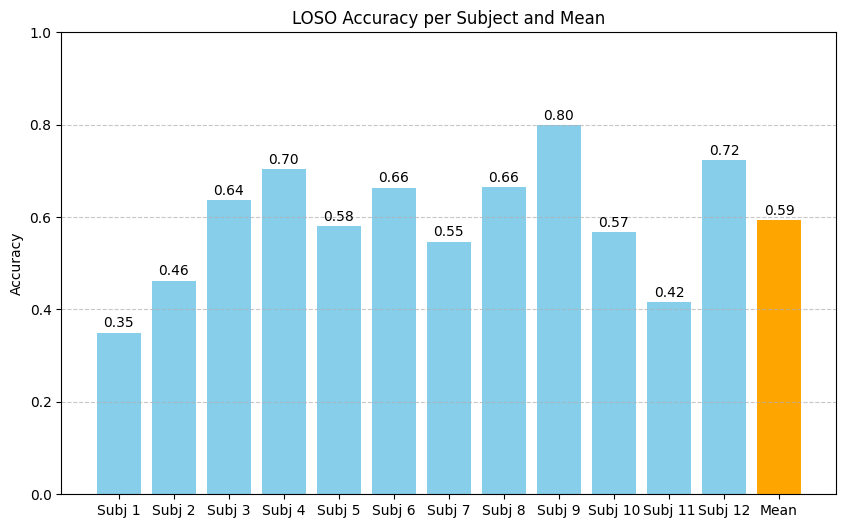

In [21]:
print(CNN_acc_list)
mean_acc = np.mean(CNN_acc_list)
std_acc = np.std(CNN_acc_list)
print(f"LOSO Mean Accuracy: {mean_acc:.4f}, Std: {std_acc:.4f}")

x_labels = [f"Subj {i}" for i in range(1, 13)] + ["Mean"]
# 对应柱子高度
y_values = CNN_acc_list + [mean_acc]

# 绘制柱状图
plt.figure(figsize=(10,6))
bars = plt.bar(x_labels, y_values, color=['skyblue']*12 + ['orange'])

# 在柱子上显示数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.2f}", ha='center', va='bottom')

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("LOSO Accuracy per Subject and Mean")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()